In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadicanmunis","key":"f7df984e4726af6a5db846149e807b9c"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d hadicanmunis/plantvillage

 99% 353M/355M [00:09<00:00, 45.5MB/s]
100% 355M/355M [00:09<00:00, 39.9MB/s]


In [4]:
!unzip -qq plantvillage.zip

In [5]:
import os, shutil, pathlib
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [6]:
train_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation/train")
test_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation/test")

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (256, 256)
batch_size = 64

train_ds, val_ds = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    image_size=image_size,
    seed=42,
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 18195 files belonging to 15 classes.
Using 14556 files for training.
Using 3639 files for validation.
Found 4591 files belonging to 15 classes.


In [8]:
for data_batch, labels_batch in train_ds:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     break

data batch shape: (64, 256, 256, 3)
labels batch shape: (64, 15)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(256, 256, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                        

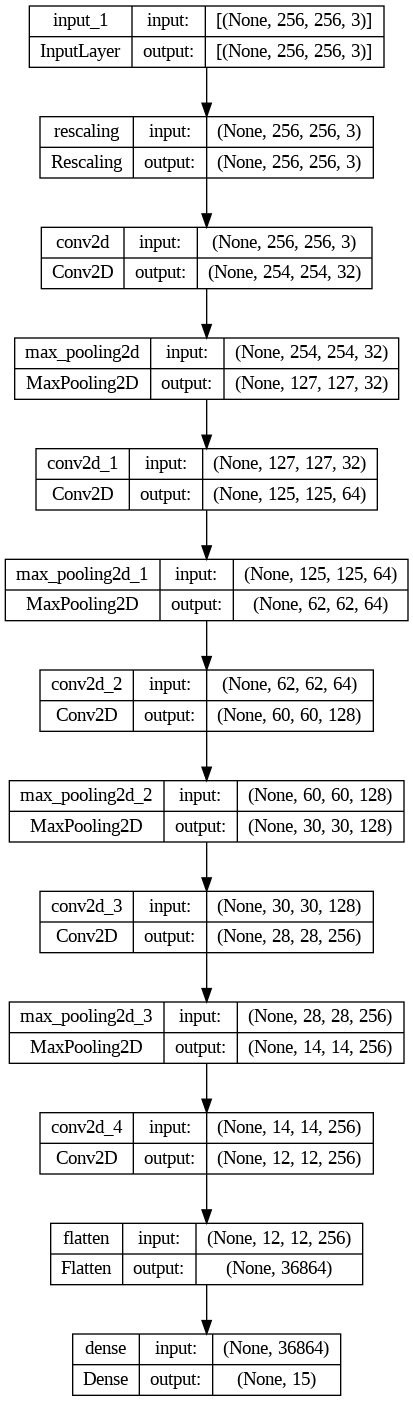

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="first_baseline_model_2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/30
228/228 [==============================] - 21s 67ms/step - loss: 1.3252 - accuracy: 0.5706 - val_loss: 0.7383 - val_accuracy: 0.7472
Epoch 2/30
228/228 [==============================] - 14s 61ms/step - loss: 0.5609 - accuracy: 0.8089 - val_loss: 0.5579 - val_accuracy: 0.8266
Epoch 3/30
228/228 [==============================] - 14s 61ms/step - loss: 0.3833 - accuracy: 0.8721 - val_loss: 0.4491 - val_accuracy: 0.8612
Epoch 4/30
228/228 [==============================] - 14s 61ms/step - loss: 0.2566 - accuracy: 0.9123 - val_loss: 0.3845 - val_accuracy: 0.8865
Epoch 5/30
228/228 [==============================] - 14s 61ms/step - loss: 0.1951 - accuracy: 0.9316 - val_loss: 0.4004 - val_accuracy: 0.8917
Epoch 6/30
228/228 [==============================] - 14s 61ms/step - loss: 0.1352 - accuracy: 0.9529 - val_loss: 0.3514 - val_accuracy: 0.9079
Epoch 7/30
228/228 [==============================] - 14s 60ms/step - loss: 0.1078 - accuracy: 0.9626 - val_loss: 0.4311 - val_accuracy:

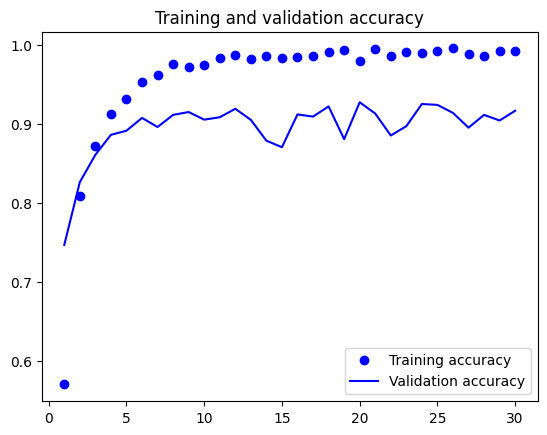

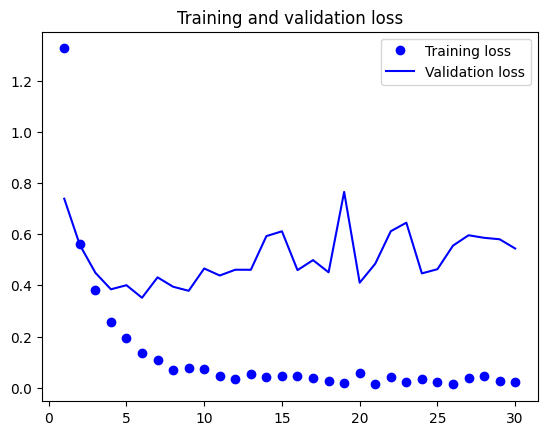

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
test_model = keras.models.load_model("first_baseline_model_2.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

72/72 [==============================] - 3s 35ms/step - loss: 0.2910 - accuracy: 0.9109
Test accuracy: 0.911


In [16]:
y_pred = test_model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)

72/72 [==============================] - 2s 27ms/step


In [17]:
import tensorflow as tf

true_categories = tf.concat([y for x, y in test_ds], axis=0)
y_true = np.argmax(true_categories, axis=1)

In [18]:
y_true

array([ 0,  0,  0, ..., 14, 14, 14])

In [19]:
predicted_labels

array([ 0,  0,  0, ..., 14, 14, 14])

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, predicted_labels)

In [21]:
print(classification_report(y_true, predicted_labels, target_names = train_ds.class_names))

                                               precision    recall  f1-score   support

                Pepper,_bell___Bacterial_spot       0.90      0.83      0.86       220
                       Pepper,_bell___healthy       0.99      0.93      0.96       296
                        Potato___Early_blight       0.90      0.99      0.94       200
                         Potato___Late_blight       0.86      0.83      0.84       200
                             Potato___healthy       0.77      0.84      0.81        32
                      Tomato___Bacterial_spot       0.90      0.96      0.93       426
                        Tomato___Early_blight       0.74      0.69      0.71       200
                         Tomato___Late_blight       0.80      0.86      0.83       381
                           Tomato___Leaf_Mold       0.88      0.92      0.90       192
                  Tomato___Septoria_leaf_spot       0.85      0.84      0.85       355
Tomato___Spider_mites Two-spotted_spider_m

<Axes: >

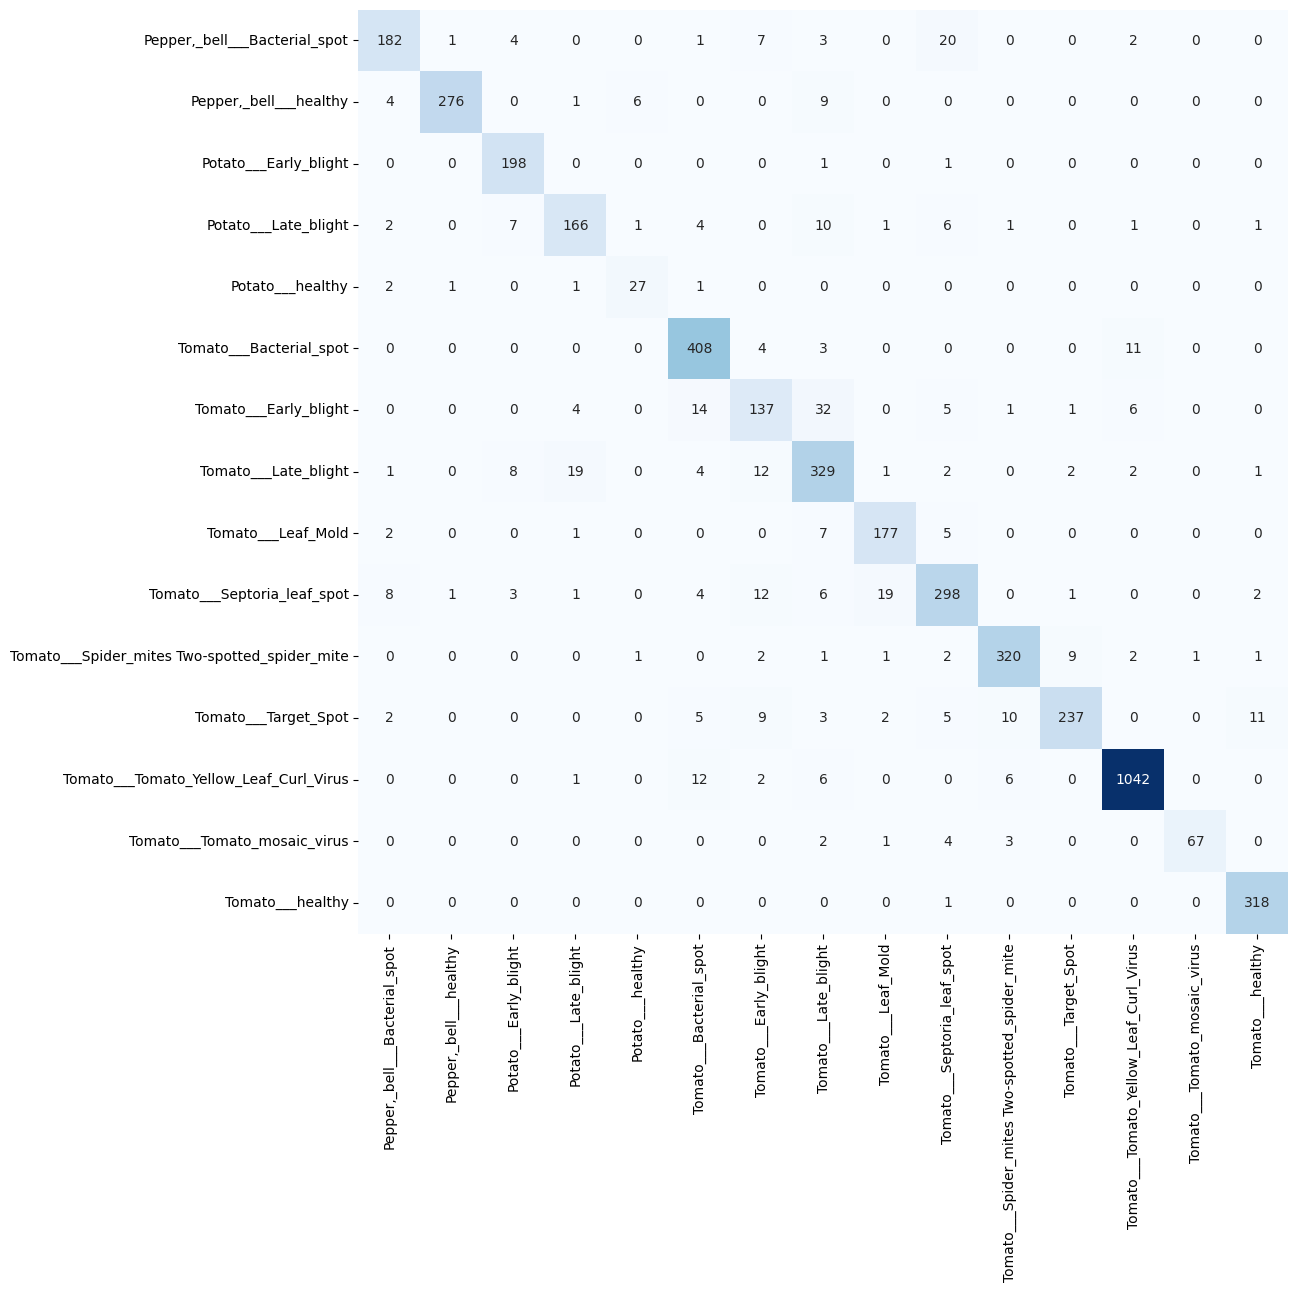

In [22]:
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)